##Image Classification on CIFAR-10
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. Make sure that you are familiar with torch `Tensor`s, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`), ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

We will use Colab because it has free GPU runtimes available; GPUs can accelerate training times for this problem by 10-100x. **You will need to enable the GPU runtime to use it**. To do so, click "Runtime" above and then "Change runtime type". There under hardware accelerator choose "GPU".

This notebook provides some starter code for the CIFAR-10 problem on HW4, including a completed training loop to assist with some of the Pytorch setup. You'll need to modify this code to implement the layers required for the assignment, but this provides a working training loop to start from.

*Note: GPU runtimes are limited on Colab. Limit your training to short-running jobs (around 20mins or less) and spread training out over time, if possible. Colab WILL limit your usage of GPU time, so plan ahead and be prepared to take breaks during training.* We also suggest performing your early coding/sweeps on a small fraction of the dataset (~10%) to minimize training time and GPU usage.

In [1]:
import torch
from torch import nn

from typing import Tuple, Union, List, Callable
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

Let's verify that we are using a gpu:

In [2]:
assert torch.cuda.is_available(), "GPU is not available, check the directions above (or disable this assertion to use CPU)"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

cuda


To use the GPU you will need to send both the model and data to a device; this transfers the model from its default location on CPU to the GPU.

Note that torch operations on Tensors will fail if they are not located on the same device.

```python
model = model.to(DEVICE)  # Sending a model to GPU

for x, y in tqdm(data_loader):
  x, y = x.to(DEVICE), y.to(DEVICE)
```
When reading tensors you may need to send them back to cpu, you can do so with `x = x.cpu()`.

Let's load CIFAR-10 data. This is how we load datasets using PyTorch in the real world!

In [3]:
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Here, we'll use the torch `DataLoader` to wrap our datasets. `DataLoader`s handle batching, shuffling, and iterating over data; they can also be useful for building more complex input pipelines that perform transfoermations such as data augmentation.

In [4]:
batch_size = 128

train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

##For Reference: Logistic Regression

This problem is about deep learning architectures, not pytorch. We are providing an implementation of logistic regression using SGD in torch, which can serve as a template for the rest of your implementation in this problem.

Before we get started, let's take a look at our data to get an understanding of what we are doing. CIFAR-10 is a dataset containing images split into 10 classes.

A single batch of images has shape: torch.Size([128, 3, 32, 32])
A single RGB image has 3 channels, width 32, and height 32.
Size of a batch of images flattened with view: torch.Size([128, 3072])
Size of a batch of images flattened with flatten: torch.Size([128, 3072])
True
This image is labeled as class automobile


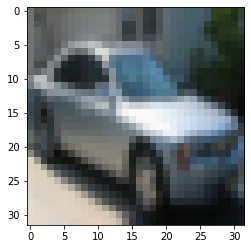

In [5]:
imgs, labels = next(iter(train_loader))
print(f"A single batch of images has shape: {imgs.size()}")
example_image, example_label = imgs[0], labels[0]
c, w, h = example_image.size()
print(f"A single RGB image has {c} channels, width {w}, and height {h}.")

# This is one way to flatten our images
batch_flat_view = imgs.view(-1, c * w * h)
print(f"Size of a batch of images flattened with view: {batch_flat_view.size()}")

# This is another equivalent way
batch_flat_flatten = imgs.flatten(1)
print(f"Size of a batch of images flattened with flatten: {batch_flat_flatten.size()}")

# The new dimension is just the product of the ones we flattened
d = example_image.flatten().size()[0]
print(c * w * h == d)

# View the image
t =  torchvision.transforms.ToPILImage()
plt.imshow(t(example_image))

# These are what the class labels in CIFAR-10 represent. For more information,
# visit https://www.cs.toronto.edu/~kriz/cifar.html
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
           "horse", "ship", "truck"]
print(f"This image is labeled as class {classes[example_label]}")


In this problem, we will attempt to predict what class an image is labeled as.

First, let's create our model. For a linear model we could flatten the data before passing it into the model, but that is not be the case for the convolutional neural network.

In [6]:
def linear_model() -> nn.Module:
  """Instantiate a linear model and send it to device."""
  model =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, 10)
         )
  return model.to(DEVICE)

In [7]:
def neural_network_A(M: int) -> nn.Module:
  """
  Instantiate the model with 1 fully-connected hidden layer for part a and send
  it to device.
  """
  model =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, M),
            nn.ReLU(),
            nn.Linear(M, 10)
         )
  return model.to(DEVICE)

In [31]:
def neural_network_B(M: int, k: int, N: int) -> nn.Module:
  """
  Instantiate the model with a convolutional layer with max-pool and fully
  connnected output for part b and send it to device.

  Inputs: 
    M: number of filters (100)
    k: size of filters (5)
    N: size of max-pool (14)

  Returns:
    nn.Module
  """
  n_conv = int(M * ((33 - k) / N)**2)
  model =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=M, kernel_size=k),
            nn.ReLU(),
            nn.MaxPool2d(N),
            nn.Flatten(),
            nn.Linear(n_conv, 10))
  return model.to(DEVICE)

Let's define a method to train this model using SGD as our optimizer.

In [9]:
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
    )-> Tuple[List[float], List[float], List[float], List[float]]:
  """
  Trains a model for the specified number of epochs using the loaders.

  Returns: 
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
  """

  loss = nn.CrossEntropyLoss()
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  for e in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    # Main training loop; iterate over train_loader. The loop
    # terminates when the train loader finishes iterating, which is one epoch.
    for (x_batch, labels) in train_loader:
      x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
      optimizer.zero_grad()
      labels_pred = model(x_batch)
      batch_loss = loss(labels_pred, labels)
      train_loss = train_loss + batch_loss.item()

      labels_pred_max = torch.argmax(labels_pred, 1)
      batch_acc = torch.sum(labels_pred_max == labels)
      train_acc = train_acc + batch_acc.item()

      batch_loss.backward()
      optimizer.step()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / (batch_size * len(train_loader)))

    # Validation loop; use .no_grad() context manager to save memory.
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
      for (v_batch, labels) in val_loader:
        v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
        labels_pred = model(v_batch)
        v_batch_loss = loss(labels_pred, labels)
        val_loss = val_loss + v_batch_loss.item()

        v_pred_max = torch.argmax(labels_pred, 1)
        batch_acc = torch.sum(v_pred_max == labels)
        val_acc = val_acc + batch_acc.item()
      val_losses.append(val_loss / len(val_loader))
      val_accuracies.append(val_acc / (batch_size * len(val_loader)))

  return train_losses, train_accuracies, val_losses, val_accuracies


For this problem, we will be using SGD. The two hyperparameters for our linear model trained with SGD are the learning rate and momentum. Only learning rate will be searched for in this example.

Note: We ask you to plot the accuracies for the best 5 models for each structure, so you will need to return multiple sets of hyperparameters for the homework, or, if you do random search, run your hyperparameter search multiple times.

In [10]:
print(torch.linspace(d/2, 972, 3, dtype=int))

tensor([1536, 1254,  972])


In [11]:
def parameter_search(train_loader: DataLoader, 
                     val_loader: DataLoader, 
                     model_fn:Callable[[], nn.Module]) -> float:
  """
  Parameter search for our linear model using SGD.

  Args:
    train_loader: the train dataloader.
    val_loader: the validation dataloader.
    model_fn: a function that, when called, returns a torch.nn.Module.

  Returns:
    The learning rate with the least validation loss.
    NOTE: you may need to modify this function to search over and return
     other parameters beyond learning rate.
  """
  num_iter = 4
  losses = {}

  lrs = torch.linspace(10 ** (-3), 10 ** (-1), num_iter)
  momentums = [0.5, 0.9, 0.99]
  Ms = torch.linspace(d/2, 972, 3, dtype=int)

  for lr in lrs:
    for mom in momentums:
      for M in Ms:
        print(f"trying learning rate {lr:0.3f}, momentum {mom}, M {M}")
        model = model_fn(M)
        optim = SGD(model.parameters(), lr, momentum=mom)

        train_loss, train_acc, val_loss, val_acc = train(
            model,
            optim,
            train_loader,
            val_loader,
            epochs=3
            )
        print(f"loss: {min(val_loss)}")
        
        losses[min(val_loss)] = (lr, mom, M)

  return losses

In [38]:
def parameter_search_B(train_loader: DataLoader, 
                     val_loader: DataLoader, 
                     model_fn:Callable[[], nn.Module]) -> float:
  """
  Parameter search for our linear model using SGD.

  Args:
    train_loader: the train dataloader.
    val_loader: the validation dataloader.
    model_fn: a function that, when called, returns a torch.nn.Module.

  Returns:
    The learning rate with the least validation loss.
    NOTE: you may need to modify this function to search over and return
     other parameters beyond learning rate.
  """
  losses = {}

  lrs = torch.linspace(10 ** (-3), 10 ** (-1), 4)
  momentums = [0.9, 0.99]
  Ms = torch.linspace(2000, 400, 4, dtype=int)
  k = 5
  N = 14

  for lr in lrs:
    for mom in momentums:
      for M in Ms:
        print(f"trying learning rate {lr:0.3f}, momentum {mom}, M {M}")
        model = model_fn(M=M, k=k, N=N)
        optim = SGD(model.parameters(), lr, momentum=mom)

        train_loss, train_acc, val_loss, val_acc = train(
            model,
            optim,
            train_loader,
            val_loader,
            epochs=3
            )
        print(f"loss: {min(val_loss)}")
        
        losses[min(val_loss)] = (lr, mom, M)

  return losses

Now that we have everything, we can train and evaluate our model.

In [12]:
%%time
losses_A = parameter_search(train_loader, val_loader, neural_network_A)


trying learning rate 0.001, momentum 0.5, M 1536
loss: 2.033295002579689
trying learning rate 0.001, momentum 0.5, M 1254
loss: 2.0398558616638183
trying learning rate 0.001, momentum 0.5, M 972
loss: 2.0403724044561384
trying learning rate 0.001, momentum 0.9, M 1536
loss: 1.8431220084428788
trying learning rate 0.001, momentum 0.9, M 1254
loss: 1.8469954937696458
trying learning rate 0.001, momentum 0.9, M 972
loss: 1.8355518877506256
trying learning rate 0.001, momentum 0.99, M 1536
loss: 1.6031416177749633
trying learning rate 0.001, momentum 0.99, M 1254
loss: 1.6141704738140106
trying learning rate 0.001, momentum 0.99, M 972
loss: 1.6337729126214982
trying learning rate 0.034, momentum 0.5, M 1536
loss: 1.6523005783557891
trying learning rate 0.034, momentum 0.5, M 1254
loss: 1.6756217032670975
trying learning rate 0.034, momentum 0.5, M 972
loss: 1.6910900503396988
trying learning rate 0.034, momentum 0.9, M 1536
loss: 1.7742464423179627
trying learning rate 0.034, momentum 0.9

In [39]:
%%time
losses_B = parameter_search_B(train_loader, val_loader, neural_network_B)

trying learning rate 0.001, momentum 0.9, M 2000
loss: 1.7315086454153061
trying learning rate 0.001, momentum 0.9, M 1466
loss: 1.7533951938152312
trying learning rate 0.001, momentum 0.9, M 933
loss: 1.8038274198770523
trying learning rate 0.001, momentum 0.9, M 400
loss: 1.9110151946544647
trying learning rate 0.001, momentum 0.99, M 2000
loss: 1.341507402062416
trying learning rate 0.001, momentum 0.99, M 1466
loss: 1.3733620256185533
trying learning rate 0.001, momentum 0.99, M 933
loss: 1.422749677300453
trying learning rate 0.001, momentum 0.99, M 400
loss: 1.4636527955532075
trying learning rate 0.034, momentum 0.9, M 2000
loss: 1.2154807671904564
trying learning rate 0.034, momentum 0.9, M 1466
loss: 1.2457669109106064
trying learning rate 0.034, momentum 0.9, M 933
loss: 1.2106488212943076
trying learning rate 0.034, momentum 0.9, M 400
loss: 1.2367557018995285
trying learning rate 0.034, momentum 0.99, M 2000
loss: 1.7377695560455322
trying learning rate 0.034, momentum 0.99

In [40]:
print("A")
for loss in sorted(losses_A)[0:5]:
  lr, mom, M = losses_A[loss]
  print(f"Loss: {loss}, lr {lr}, momentum {mom}, M {M}")

A
Loss: 1.6031416177749633, lr 0.0010000000474974513, momentum 0.99, M 1536
Loss: 1.6141704738140106, lr 0.0010000000474974513, momentum 0.99, M 1254
Loss: 1.6337729126214982, lr 0.0010000000474974513, momentum 0.99, M 972
Loss: 1.6523005783557891, lr 0.03399999812245369, momentum 0.5, M 1536
Loss: 1.6682529002428055, lr 0.06700000166893005, momentum 0.5, M 1254


In [41]:
print("B")
for loss in sorted(losses_B)[0:5]:
  lr, mom, M = losses_B[loss]
  print(f"Loss: {loss}, lr {lr}, momentum {mom}, M {M}")

B
Loss: 1.2106488212943076, lr 0.03399999812245369, momentum 0.9, M 933
Loss: 1.2154807671904564, lr 0.03399999812245369, momentum 0.9, M 2000
Loss: 1.2367557018995285, lr 0.03399999812245369, momentum 0.9, M 400
Loss: 1.2457669109106064, lr 0.03399999812245369, momentum 0.9, M 1466
Loss: 1.2549321860074998, lr 0.06700000166893005, momentum 0.9, M 1466


In [43]:
lr, mom, M = losses_B[sorted(losses_B)[0]]
model = neural_network_B(M, k=5, N=14)
optimizer = SGD(model.parameters(), lr, momentum=mom)
train_loss, train_accuracy, val_loss, val_accuracy = train(
  model, optimizer, train_loader, val_loader, 30)
print(f"Validation accuracy for best model: {max(val_accuracy)}")

Validation accuracy for best model: 0.6685546875


Plot the training and validation accuracy for each epoch, and evaluate our first model on the testing data.

In [14]:
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
  """Computes test loss and accuracy of model on loader."""
  loss = nn.CrossEntropyLoss()
  model.eval()
  test_loss = 0.0
  test_acc = 0.0
  with torch.no_grad():
    for (batch, labels) in loader:
      batch, labels = batch.to(DEVICE), labels.to(DEVICE)
      y_batch_pred = model(batch)
      batch_loss = loss(y_batch_pred, labels)
      test_loss = test_loss + batch_loss.item()

      pred_max = torch.argmax(y_batch_pred, 1)
      batch_acc = torch.sum(pred_max == labels)
      test_acc = test_acc + batch_acc.item()
    test_loss = test_loss / len(loader)
    test_acc = test_acc / (batch_size * len(loader))
    return test_loss, test_acc

Validation accuracy for best model: 0.5037109375
Test Accuracy for best model: 0.4994066455696203


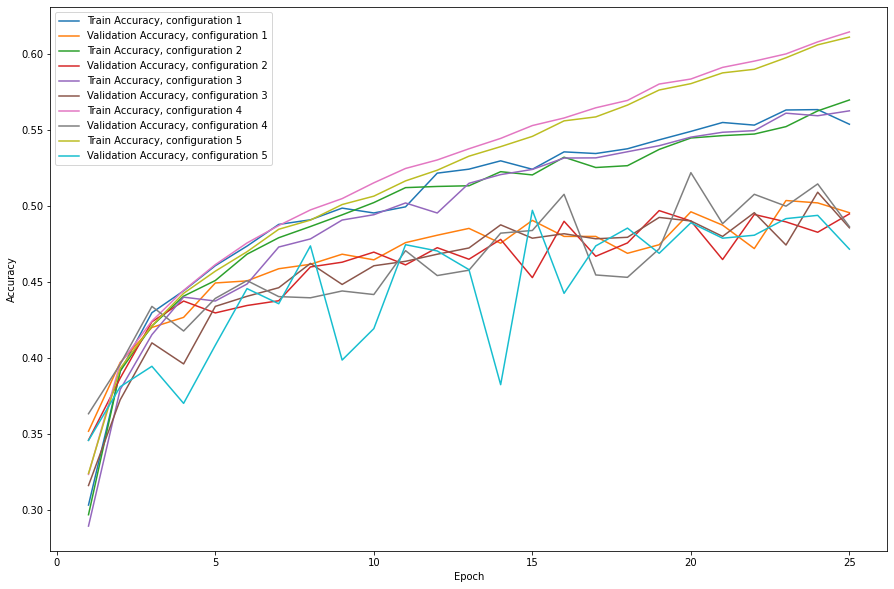

In [18]:
plt.figure(figsize=(15, 10))
for i, loss in enumerate(sorted(losses_A)[0:5]):
  lr, mom, M = losses_A[loss]
  model = neural_network_A(M)
  optimizer = SGD(model.parameters(), lr, momentum=mom)
  train_loss, train_accuracy, val_loss, val_accuracy = train(
    model, optimizer, train_loader, val_loader, 25)
  if i == 0:
    print(f"Validation accuracy for best model: {max(val_accuracy)}")
    test_loss, test_acc = evaluate(model, test_loader)
    print(f"Test Accuracy for best model: {test_acc}")

  epochs = range(1, 26)
  plt.plot(epochs, train_accuracy, label=f"Train Accuracy, configuration {i+1}")
  plt.plot(epochs, val_accuracy, label=f"Validation Accuracy, configuration {i+1}")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  #plt.title("Logistic Regression Accuracy for CIFAR-10 vs Epoch")
plt.show()

In [47]:
lr_best, mom_best, M_best = losses_A[sorted(losses_A)[4]]
model = neural_network_B(M, k=5, N=14)
optimizer = SGD(model.parameters(), lr, momentum=mom)
train_loss, train_accuracy, val_loss, val_accuracy = train(
  model, optimizer, train_loader, val_loader, 25)
print(f"Validation accuracy for best model: {max(val_accuracy)}")
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy for best model: {test_acc}")

Validation accuracy for best model: 0.61640625
Test Accuracy for best model: 0.5850474683544303


Validation accuracy for best model: 0.66171875
Test Accuracy for best model: 0.6600079113924051


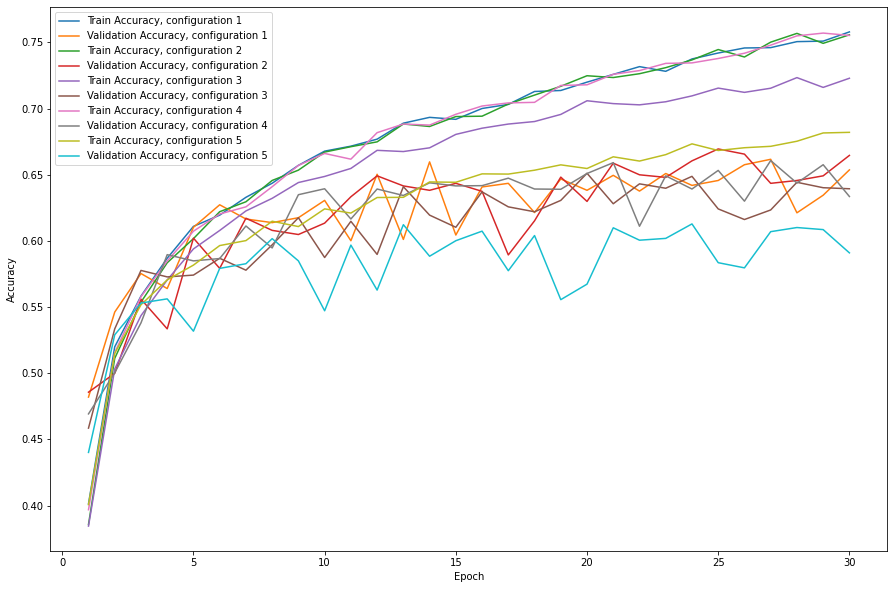

In [46]:
plt.figure(figsize=(15, 10))
for i, loss in enumerate(sorted(losses_B)[0:5]):
  lr, mom, M = losses_B[loss]
  model = neural_network_B(M, k=5, N=14)
  optimizer = SGD(model.parameters(), lr, momentum=mom)
  train_loss, train_accuracy, val_loss, val_accuracy = train(
    model, optimizer, train_loader, val_loader, 30)
  if i == 0:
    print(f"Validation accuracy for best model: {max(val_accuracy)}")
    test_loss, test_acc = evaluate(model, test_loader)
    print(f"Test Accuracy for best model: {test_acc}")

  epochs = range(1, 31)
  plt.plot(epochs, train_accuracy, label=f"Train Accuracy, configuration {i+1}")
  plt.plot(epochs, val_accuracy, label=f"Validation Accuracy, configuration {i+1}")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  #plt.title("Logistic Regression Accuracy for CIFAR-10 vs Epoch")
plt.show()